In [5]:
import theano
import theano.tensor as T
import lasagne
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
%matplotlib inline

In [6]:
# my generator
G_input = T.matrix('G_input')
G_layer1 = lasagne.layers.InputLayer((None, 2), G_input)
G_layer2 = lasagne.layers.DenseLayer(G_layer1, num_units=50, nonlinearity=rectify)
G_layer2 = lasagne.layers.DenseLayer(G_layer1, num_units=50, nonlinearity=tanh)
G_layer3 = lasagne.layers.DenseLayer(G_layer2, num_units=50, nonlinearity=rectify)
G_layer4 = lasagne.layers.DenseLayer(G_layer3, num_units=2, nonlinearity=linear)
G = G_layer4

G_out = lasagne.layers.get_output(G)

# my discriminators
D1_input = T.matrix('D1_input')
D1_layer1 = lasagne.layers.InputLayer((None, 2), D1_input)
D1_layer2 = lasagne.layers.DenseLayer(D1_layer1, num_units=20, nonlinearity=tanh)
D1_layer3 = lasagne.layers.DenseLayer(D1_layer2, num_units=20, nonlinearity=rectify)
D1_layer4 = lasagne.layers.DenseLayer(D1_layer3, num_units=20, nonlinearity=tanh)
D1_layer5 = lasagne.layers.DenseLayer(D1_layer4, num_units=1, nonlinearity=sigmoid)
D1 = D1_layer5

D2_layer1 = lasagne.layers.InputLayer((None, 2), G_out)
D2_layer2 = lasagne.layers.DenseLayer(D2_layer1, num_units=20, nonlinearity=tanh, W=D1_layer2.W, b=D1_layer2.b)
D2_layer3 = lasagne.layers.DenseLayer(D2_layer2, num_units=20, nonlinearity=rectify, W=D1_layer3.W, b=D1_layer3.b)
D2_layer4 = lasagne.layers.DenseLayer(D2_layer3, num_units=20, nonlinearity=tanh, W=D1_layer4.W, b=D1_layer4.b)
D2_layer5 = lasagne.layers.DenseLayer(D2_layer4, num_units=1, nonlinearity=sigmoid, W=D1_layer5.W, b=D1_layer5.b)
D2 = D2_layer5

D1_out = lasagne.layers.get_output(D1)
D2_out = lasagne.layers.get_output(D2)

In [7]:
def sample_noise(q):
    return np.random.uniform(-2.0, 2.0, size=(q,2))

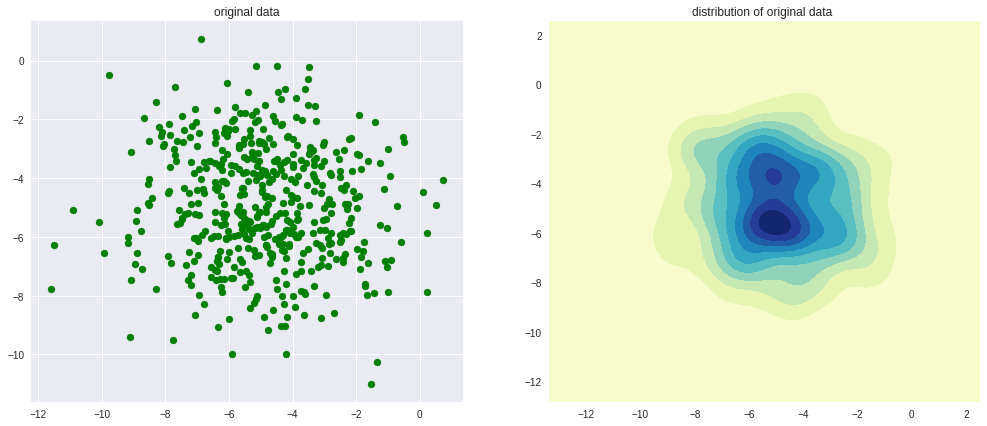

'\nax = fig.add_subplot(122, projection=\'3d\')\nx = np.linspace(-6, 6, 10)\ny = np.linspace(-6, 6, 10)\nxl, yl = np.meshgrid(x, y)\npos = np.dstack((xl, yl))\n\nprint(pos.reshape(-1,2))\n#pos = np.empty(x.shape + (2,))\nrv = multivariate_normal([mu, mu], [[sigma * sigma, 0], [0, sigma * sigma]])\nprint(rv.pdf(pos).shape, xl.shape)\n\nax.plot_surface(xl, yl, rv.pdf(pos),cmap=\'viridis\',linewidth=0)\nplt.title("distribution of original data ")\nplt.show()\n#ax.plot(xl, yl, norm.pdf(xl,yl, loc=mu, scale=sigma))'

In [8]:
data_size = 500
mu = -5
sigma = 2.
data = np.float32(np.random.normal(mu, sigma, size=(data_size, 2)))
fig = plt.figure(figsize=(17,7))
ax = fig.add_subplot(121)
ax.scatter(data[:,0], data[:,1], color='g')
plt.title("original data")

ax = fig.add_subplot(122)
sns.kdeplot(data[:,0], data[:,1], cmap='YlGnBu', shade=True)
plt.title("distribution of original data ")
plt.show()

'''
ax = fig.add_subplot(122, projection='3d')
x = np.linspace(-6, 6, 10)
y = np.linspace(-6, 6, 10)
xl, yl = np.meshgrid(x, y)
pos = np.dstack((xl, yl))

print(pos.reshape(-1,2))
#pos = np.empty(x.shape + (2,))
rv = multivariate_normal([mu, mu], [[sigma * sigma, 0], [0, sigma * sigma]])
print(rv.pdf(pos).shape, xl.shape)

ax.plot_surface(xl, yl, rv.pdf(pos),cmap='viridis',linewidth=0)
plt.title("distribution of original data ")
plt.show()
#ax.plot(xl, yl, norm.pdf(xl,yl, loc=mu, scale=sigma))'''

In [13]:
def plot_fig(generate, discriminate):
    # plots pg, pdata, decision boundary
    #plot original data distribution
    fig = plt.figure(figsize=(17, 7))
    ax = fig.add_subplot(121)
    sns.kdeplot(data[:,0], data[:,1], cmap='YlGnBu', shade=True)
    
    #plot generated data distribution
    r = 100  # resolution (number of points)
    zs = sample_noise(r)
    gs = generate(zs)
    #print(gs[:10,:])
    sns.kdeplot(gs[:,0], gs[:,1], cmap='viridis')
    plt.title('Original data and Fake data')
    
    #plot discriminator
    ax = fig.add_subplot(122, projection='3d')
    x = np.linspace(-5-5, -5+5, r)
    y = np.linspace(-5-5, -5+5, r)
    xl, yl = np.meshgrid(x, y)
    pos = np.dstack((xl, yl)).reshape((-1, 2))
    ds = discriminate(pos)
    #print(xs[:10,:], ds.flatten()[:10])
    ax.plot_surface(xl, yl, ds.reshape((r,r)), cmap='viridis', linewidth=0)
    plt.title("Discriminator")

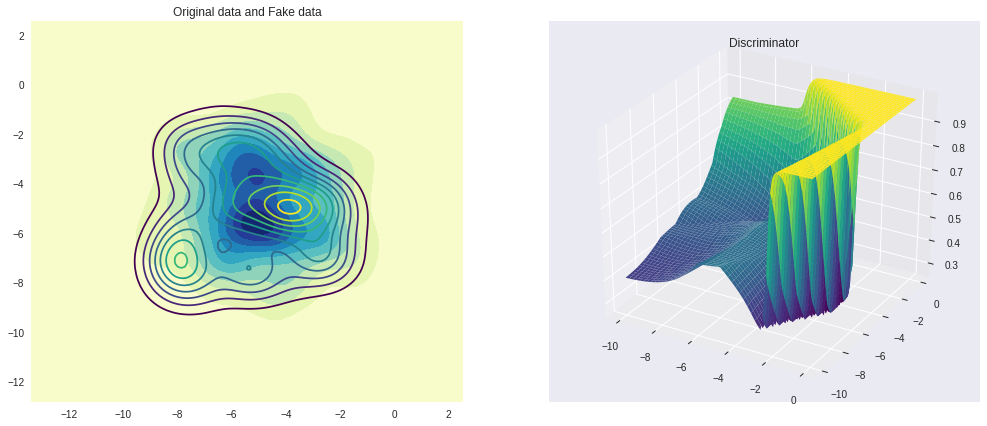

In [22]:
# losses
G_loss = -(T.log(D2_out)).mean()
D_loss = -(T.log(D1_out) + T.log(1 - D2_out)).mean()

# parameters update and training
G_weights = lasagne.layers.get_all_params(G, trainable=True)
G_updates = lasagne.updates.nesterov_momentum(G_loss, G_weights, learning_rate=0.05, momentum=0.6)
G_train = theano.function([G_input], G_loss, updates=G_updates)

D_weights = lasagne.layers.get_all_params(D1, trainable=True)
D_updates = lasagne.updates.nesterov_momentum(D_loss, D_weights, learning_rate=0.05, momentum=0.6)
D_train = theano.function([G_input, D1_input], D_loss, updates=D_updates)

des = theano.function([D1_input], D1_out)
gen = theano.function([G_input], G_out)

# training loop
#print(gen([[2.,-4.]]))
#print(des([[-8000.,-8000.]]))
epochs = 400
#data_size = 200  # mini-batch size
k = 30

for i in range(epochs):
    for j in range(k):
        noise = sample_noise(data_size)
        D_train(noise, data)
    
    noise = sample_noise(data_size)
    G_train(noise)
    #plt.clf()
    display.clear_output(wait=True)
    plot_fig(gen, des)
    plt.show()
    